In [1]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "notebook", "muted"])
plt.rcParams["text.usetex"] = False

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import pandas as pd
import pathlib
import h5py
import tqdm
import copy

import prim.waveform

import sklearn

import numpy as np

import phenom

# custom
import phenom
import prim.taylort3

from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import prim.collocation

import pandas as pd

In [2]:
df = pd.read_csv("/scratch/sebastian.khan/data/ppmHM_2024_11_11/metadata.csv")

In [3]:
df.columns

Index(['approximant', 'chi1z', 'chi2z', 'is_reference', 'modes', 'q',
       'sxs_sim_name', 'filepath', 'hybrid_name', 'q_rounded', 'chi1z_rounded',
       'chi2z_rounded', 'chi_eff', 'chi_eff_rounded', 'ID'],
      dtype='object')

In [4]:
mask_non_spin = (df['chi1z_rounded'] == 0) & (df['chi2z_rounded'] == 0)

In [5]:
df = df[mask_non_spin]
df = df.reset_index(drop=True)

In [6]:
df

approximant     chi1z     chi2z  is_reference  \
0       SEOBNRv5HM -0.000029 -0.000006          True   
1    SEOBNRv4HM_PA  0.000002  0.000005         False   
2    SEOBNRv4HM_PA -0.000003 -0.000010         False   
3       SEOBNRv5HM  0.000001  0.000001         False   
4    SEOBNRv4HM_PA  0.000012 -0.000007         False   
..             ...       ...       ...           ...   
411  SEOBNRv4HM_PA  0.000027  0.000026         False   
412  SEOBNRv4HM_PA  0.000036  0.000036         False   
413     SEOBNRv5HM  0.000146  0.000097         False   
414     SEOBNRv5HM -0.000050 -0.000011         False   
415  SEOBNRv4HM_PA  0.000004  0.000003         False   

                                                 modes         q  \
0    [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  7.499720   
1    [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  3.000099   
2    [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  5.500026   
3                      [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.000000   
4    [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  9.167300   
..                                                 ...       ...   
411                    [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.000000   
412                    [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.000000   
413  [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  1.221181   
414  [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  3.272497   
415  [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  2.999988   

          sxs_sim_name                                           filepath  \
0    SXS:BBH:2490/Lev5  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
1    SXS:BBH:2265/Lev1  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
2    SXS:BBH:2486/Lev1  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
3    SXS:BBH:2496/Lev3  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
4    SXS:BBH:0189/Lev3  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
..                 ...                                                ...   
411  SXS:BBH:1154/Lev1  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
412  SXS:BBH:2375/Lev2  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
413  SXS:BBH:0310/Lev3  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
414  SXS:BBH:0200/Lev2  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
415  SXS:BBH:2498/Lev1  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   

                          hybrid_name  q_rounded  chi1z_rounded  \
0       SXS_BBH_2490-Lev5__SEOBNRv5HM      7.500           -0.0   
1    SXS_BBH_2265-Lev1__SEOBNRv4HM_PA      3.000            0.0   
2    SXS_BBH_2486-Lev1__SEOBNRv4HM_PA      5.500           -0.0   
3       SXS_BBH_2496-Lev3__SEOBNRv5HM      1.000            0.0   
4    SXS_BBH_0189-Lev3__SEOBNRv4HM_PA      9.167            0.0   
..                                ...        ...            ...   
411  SXS_BBH_1154-Lev1__SEOBNRv4HM_PA      1.000            0.0   
412  SXS_BBH_2375-Lev2__SEOBNRv4HM_PA      1.000            0.0   
413     SXS_BBH_0310-Lev3__SEOBNRv5HM      1.221            0.0   
414     SXS_BBH_0200-Lev2__SEOBNRv5HM      3.272           -0.0   
415  SXS_BBH_2498-Lev1__SEOBNRv4HM_PA      3.000            0.0   

     chi2z_rounded   chi_eff  chi_eff_rounded   ID  
0             -0.0 -0.000026          -0.0000    2  
1              0.0  0.000003           0.0000  279  
2             -0.0 -0.000004          -0.0000   88  
3              0.0  0.000001           0.0000  157  
4             -0.0  0.000010           0.0000  164  
..             ...       ...              ...  ...  
411            0.0  0.000026           0.0000  157  
412            0.0  0.000036           0.0000  157  
413            0.0  0.000124           0.0001  341  
414           -0.0 -0.000041          -0.0000  196  
415            0.0  0.000004           0.0000  279  

[416 rows x 15 columns]

In [7]:
df[df["ID"]==157]

approximant     chi1z     chi2z  is_reference  \
3       SEOBNRv5HM  0.000001  0.000001         False   
9    SEOBNRv4HM_PA  0.000020  0.000020         False   
21   SEOBNRv4HM_PA  0.000036  0.000037         False   
24      SEOBNRv5HM  0.000114  0.000113         False   
26      SEOBNRv5HM  0.000036  0.000036         False   
..             ...       ...       ...           ...   
397  SEOBNRv4HM_PA -0.000053 -0.000053         False   
398     SEOBNRv5HM  0.000036  0.000037         False   
408  SEOBNRv4HM_PA  0.000012  0.000013         False   
411  SEOBNRv4HM_PA  0.000027  0.000026         False   
412  SEOBNRv4HM_PA  0.000036  0.000036         False   

                               modes    q       sxs_sim_name  \
3    [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:2496/Lev3   
9    [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:2326/Lev1   
21   [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:2378/Lev1   
24   [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:3632/Lev1   
26   [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:2376/Lev3   
..                               ...  ...                ...   
397  [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:0389/Lev1   
398  [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:2378/Lev3   
408  [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:3624/Lev1   
411  [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:1154/Lev1   
412  [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.0  SXS:BBH:2375/Lev2   

                                              filepath  \
3    /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
9    /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
21   /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
24   /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
26   /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
..                                                 ...   
397  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
398  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
408  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
411  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
412  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   

                          hybrid_name  q_rounded  chi1z_rounded  \
3       SXS_BBH_2496-Lev3__SEOBNRv5HM        1.0            0.0   
9    SXS_BBH_2326-Lev1__SEOBNRv4HM_PA        1.0            0.0   
21   SXS_BBH_2378-Lev1__SEOBNRv4HM_PA        1.0            0.0   
24      SXS_BBH_3632-Lev1__SEOBNRv5HM        1.0            0.0   
26      SXS_BBH_2376-Lev3__SEOBNRv5HM        1.0            0.0   
..                                ...        ...            ...   
397  SXS_BBH_0389-Lev1__SEOBNRv4HM_PA        1.0           -0.0   
398     SXS_BBH_2378-Lev3__SEOBNRv5HM        1.0            0.0   
408  SXS_BBH_3624-Lev1__SEOBNRv4HM_PA        1.0            0.0   
411  SXS_BBH_1154-Lev1__SEOBNRv4HM_PA        1.0            0.0   
412  SXS_BBH_2375-Lev2__SEOBNRv4HM_PA        1.0            0.0   

     chi2z_rounded   chi_eff  chi_eff_rounded   ID  
3              0.0  0.000001           0.0000  157  
9              0.0  0.000020           0.0000  157  
21             0.0  0.000036           0.0000  157  
24             0.0  0.000113           0.0001  157  
26             0.0  0.000036           0.0000  157  
..             ...       ...              ...  ...  
397           -0.0 -0.000053          -0.0001  157  
398            0.0  0.000036           0.0000  157  
408            0.0  0.000013           0.0000  157  
411            0.0  0.000026           0.0000  157  
412            0.0  0.000036           0.0000  157  

[90 rows x 15 columns]

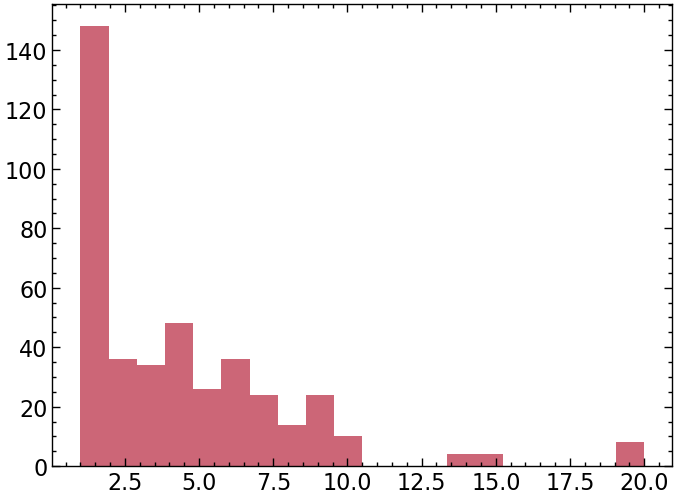

In [8]:
plt.figure()
plt.hist(df['q_rounded'], bins=20);

In [9]:
def load_hybrid_h5_file(hybrid_file, return_metadata=False):
    with h5py.File(hybrid_file, 'r') as f:
        hybrid_metadata = list(f.attrs.items())+[('filename', hybrid_file)]

        times = f['times'][:]
        hlms={}
        for l,m in f.attrs['modes']:
            hlms[l,m] = f[f"hlm_l{l}_m{m}"][:]

        hybrid_wf = prim.waveform.Waveform(times, hlms)

    if return_metadata:
        return hybrid_metadata, hybrid_wf
    else:
        return hybrid_wf

In [ ]:
df.iloc[i]['filepath']

In [10]:
%%time
wfs=[]
qs = []
for i in tqdm.trange(len(df)):
    # at least some of the q7s have strange merger amp peaks
    if df.iloc[i]['q_rounded'] == 7:
        continue
    wf_ = load_hybrid_h5_file(df.iloc[i]['filepath'])
    wf_.compute_amplitude()#.compute_frequency()
    wfs.append(wf_)
    qs.append(df.iloc[i]['q_rounded'])
qs=np.array(qs)

100%|██████████| 416/416 [01:10<00:00,  5.94it/s]

CPU times: user 6.97 s, sys: 16.1 s, total: 23.1 s
Wall time: 1min 10s


In [11]:
def get_peak_amp(wfs, mode):
    peak_amps=[]
    for wf_ in wfs:
        try:
            peak_amp = np.max(wf_.amplitudes[mode])
        except:
            peak_amp = 0
        peak_amps.append(peak_amp)
    peak_amps = np.array(peak_amps)
    return peak_amps

In [12]:
modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3), (5,5), (5,4)]

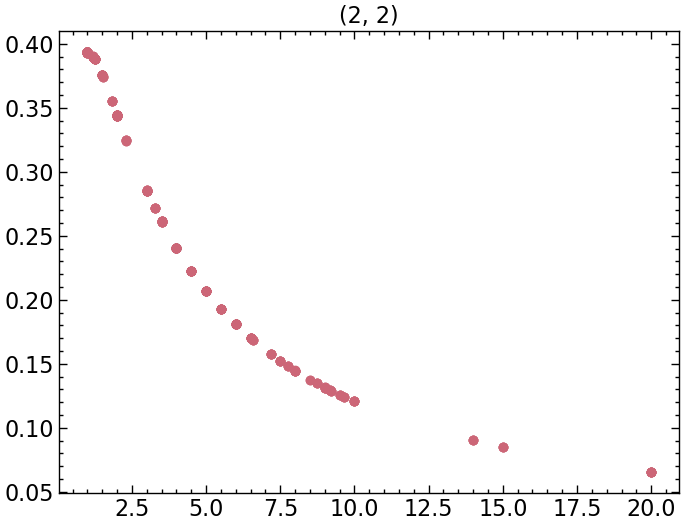

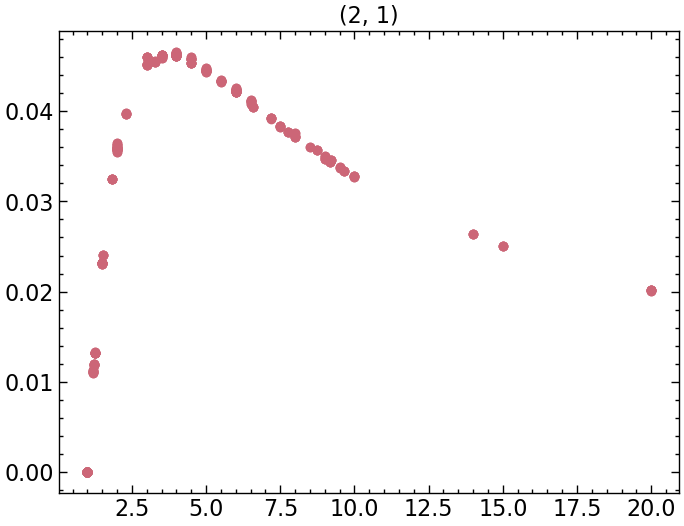

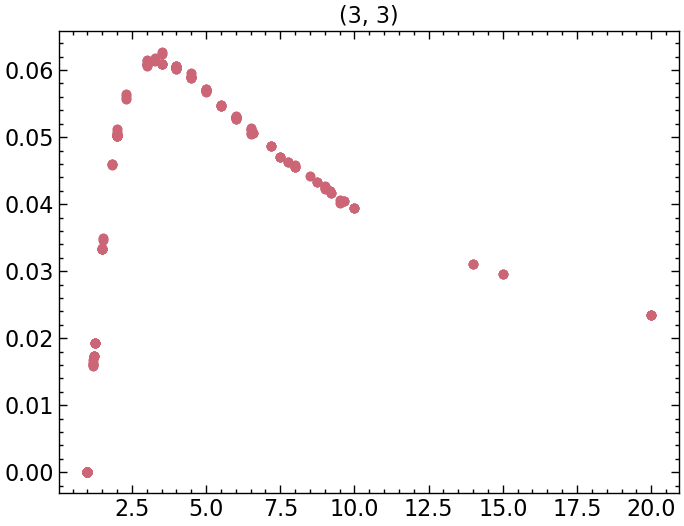

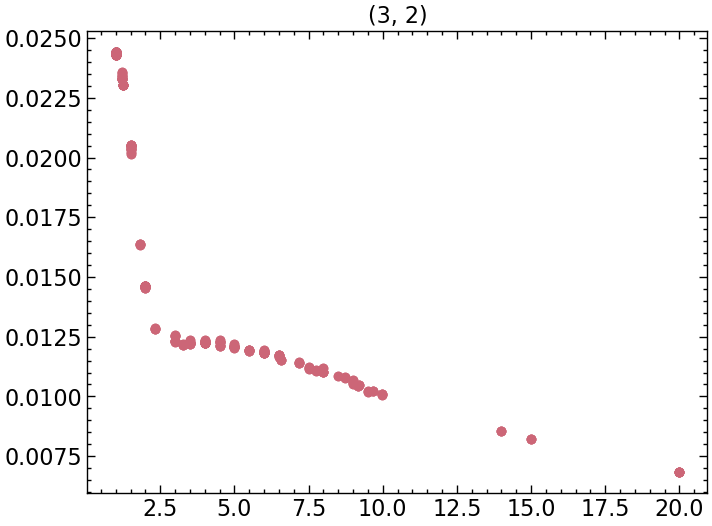

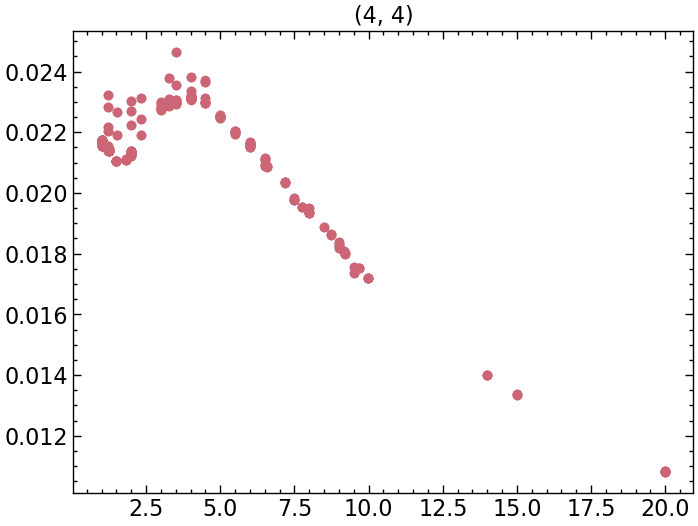

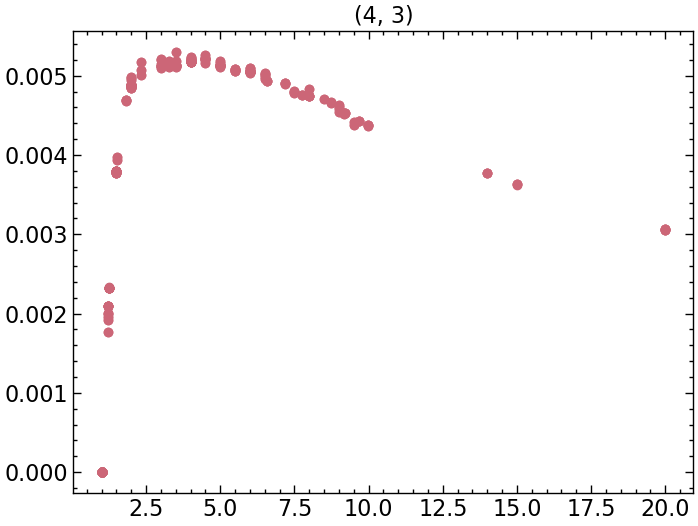

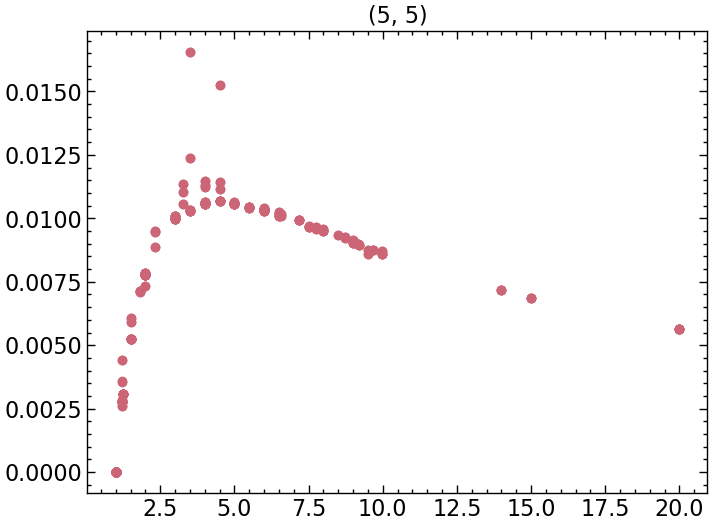

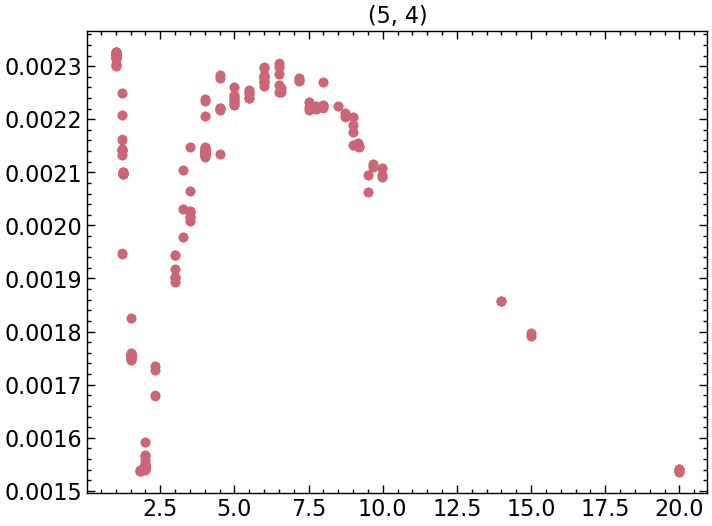

In [13]:
for mode in modes:
    plt.figure()
    # plt.scatter(df['q_rounded'], get_peak_amp(wfs, mode))
    plt.scatter(qs, get_peak_amp(wfs, mode))
    plt.title(mode)
    plt.show()
    plt.close()

In [13]:
import rfflearn.tuner
import rfflearn.cpu
import sklearn.preprocessing
import sklearn.model_selection

In [63]:
def fit_rffgpr(X, y, n_trials=100, fit_noise=True, std_scale=1):
    X = np.array(X)
    # add y(eta=0) = 0
    # X = np.concatenate([X, [0]])
    # y = np.concatenate([y, [0]])

    X = X[:,np.newaxis]
    

    
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)


    y_ss = sklearn.preprocessing.StandardScaler()
    y_train = y_ss.fit_transform(y_train[:,np.newaxis])[:,0]
    y_test = y_ss.transform(y_test[:,np.newaxis])[:,0]

    if fit_noise:
        study = rfflearn.tuner.RFF_dim_std_err_tuner(
            rfflearn.cpu.RFFGPR,
            train_set=(X_train, y_train),
            valid_set=(X_test, y_test),
            verbose=3,
            n_trials=n_trials,
            **{
                "dtype_dim_kernel": "int",
                # "range_dim_kernel": {"low": 128, "high": 1024},
                "range_dim_kernel": {"low": 32, "high": 256},
                "dtype_std_error" : "float",
                "range_std_error" : {"low": 1e-1, "high": 1, "log": False},
                "dtype_std_kernel" : "float",
                "range_std_kernel": {"low": 1e-3, "high": 50, "log": True},
                "show_progress_bar":True
            }
        )
    else:
        study = rfflearn.tuner.RFF_dim_std_tuner(
            rfflearn.cpu.RFFGPR,
            train_set=(X_train, y_train),
            valid_set=(X_test, y_test),
            verbose=3,
            n_trials=n_trials,
            std_error=y_train.std() * std_scale,
            **{
                "dtype_dim_kernel": "int",
                # "range_dim_kernel": {"low": 128, "high": 1024},
                "range_dim_kernel": {"low": 32, "high": 256},
                "dtype_std_kernel" : "float",
                "range_std_kernel": {"low": 1e-3, "high": 50, "log": True},
                "show_progress_bar":True
            }
        )

    # refit best model with all data?
    model = copy.deepcopy(study.user_attrs["best_model"])
    y = y_ss.transform(y[:,np.newaxis])[:,0]
    model.fit(X, y)

    return study, y_ss, model

In [64]:
%%time
study={}
y_ss={}
model={}
for mode in modes:
    print(mode)
    # study[mode], y_ss[mode], model[mode] = fit_rffgpr(df['q_rounded'], get_peak_amp(wfs, mode))
    study[mode], y_ss[mode], model[mode] = fit_rffgpr(phenom.eta_from_q(qs), get_peak_amp(wfs, mode), n_trials=100, fit_noise=True, std_scale=1/4)

(2, 2)


  0%|          | 0/100 [00:00<?, ?it/s]

(2, 1)


  0%|          | 0/100 [00:00<?, ?it/s]

(3, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

(3, 2)


  0%|          | 0/100 [00:00<?, ?it/s]

(4, 4)


  0%|          | 0/100 [00:00<?, ?it/s]

(4, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

(5, 5)


  0%|          | 0/100 [00:00<?, ?it/s]

(5, 4)


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 34.8 s, sys: 543 ms, total: 35.4 s
Wall time: 35 s


In [65]:
xx = np.linspace(phenom.eta_from_q(23), 0.25, 1000)[:,np.newaxis]

In [66]:
# Show the result of the hyper parameter tuning.
for mode in modes:
    print(f"{mode = }")
    print("- study.best_params:", study[mode].best_params)
    print("- study.best_value:",  study[mode].best_value)
    # print("- study.best_model:",  study[mode].user_attrs["best_model"])

mode = (2, 2)
- study.best_params: {'dim_kernel': 228, 'std_kernel': 29.541804992777138, 'std_error': 0.10270240681617981}
- study.best_value: 0.999997037139652
mode = (2, 1)
- study.best_params: {'dim_kernel': 251, 'std_kernel': 38.71555317224121, 'std_error': 0.12362390957502625}
- study.best_value: 0.9978537572968191
mode = (3, 3)
- study.best_params: {'dim_kernel': 173, 'std_kernel': 49.767227760060344, 'std_error': 0.23442277647838944}
- study.best_value: 0.9970066524870737
mode = (3, 2)
- study.best_params: {'dim_kernel': 200, 'std_kernel': 48.221444641648304, 'std_error': 0.6156638699169217}
- study.best_value: 0.9998405014759619
mode = (4, 4)
- study.best_params: {'dim_kernel': 158, 'std_kernel': 39.18820490490221, 'std_error': 0.42664614355176544}
- study.best_value: 0.9666816226240651
mode = (4, 3)
- study.best_params: {'dim_kernel': 245, 'std_kernel': 49.812254963048986, 'std_error': 0.16564968759025284}
- study.best_value: 0.9970479187199969
mode = (5, 5)
- study.best_param

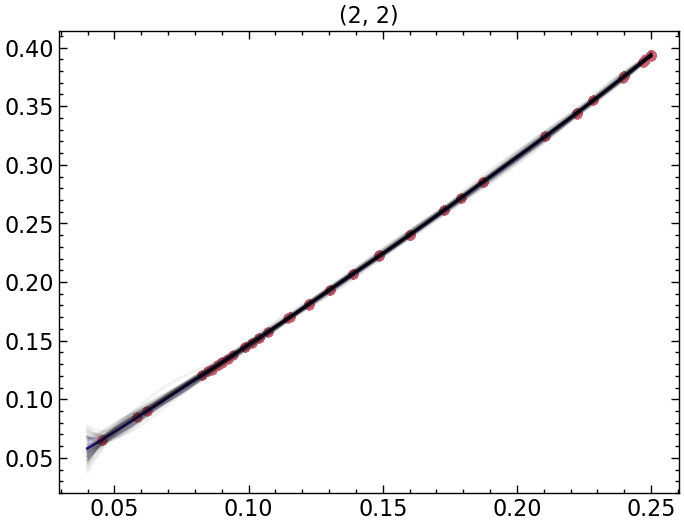

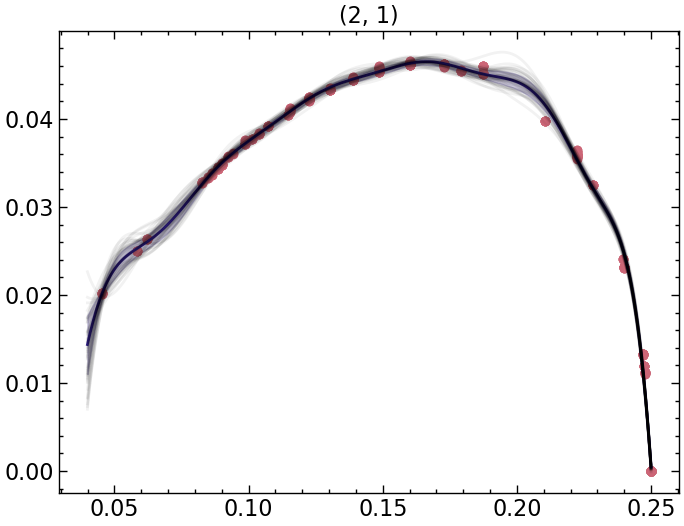

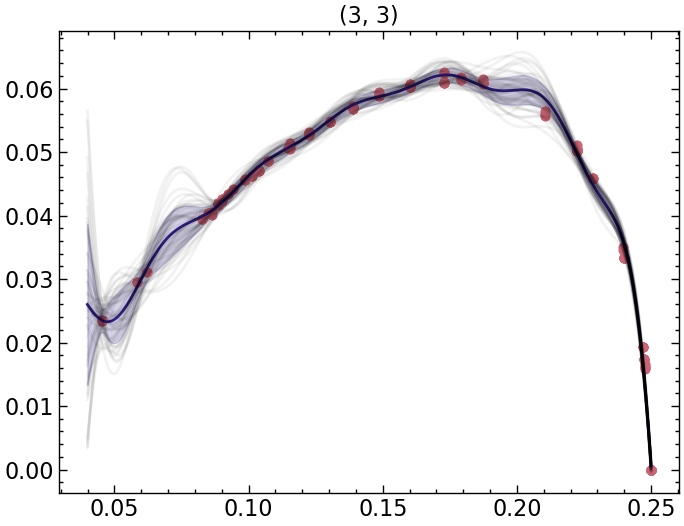

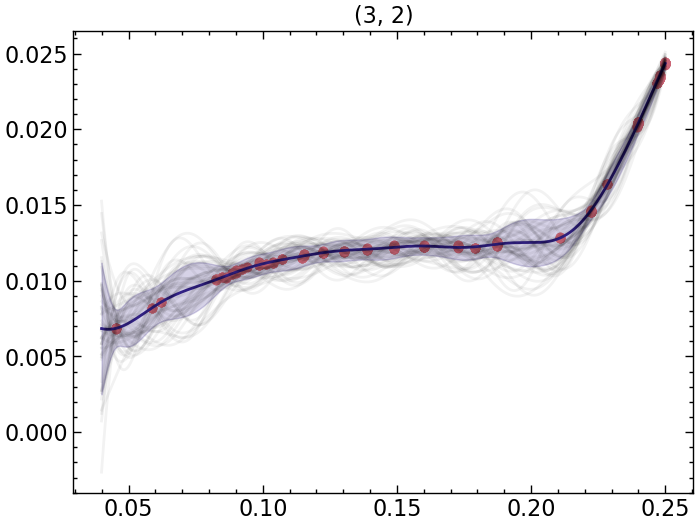

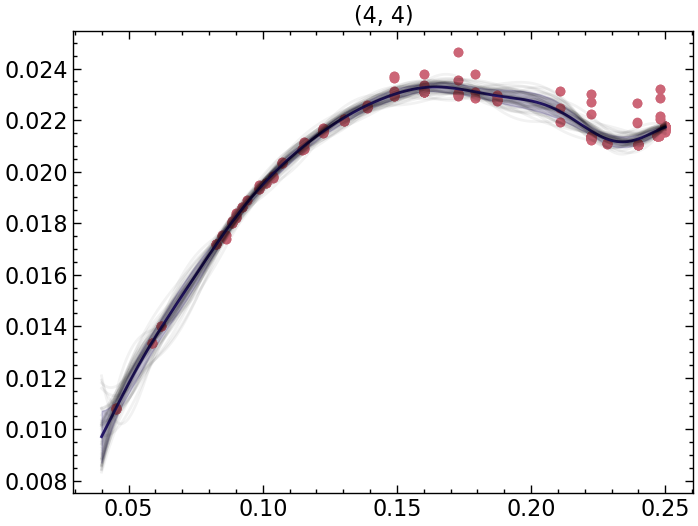

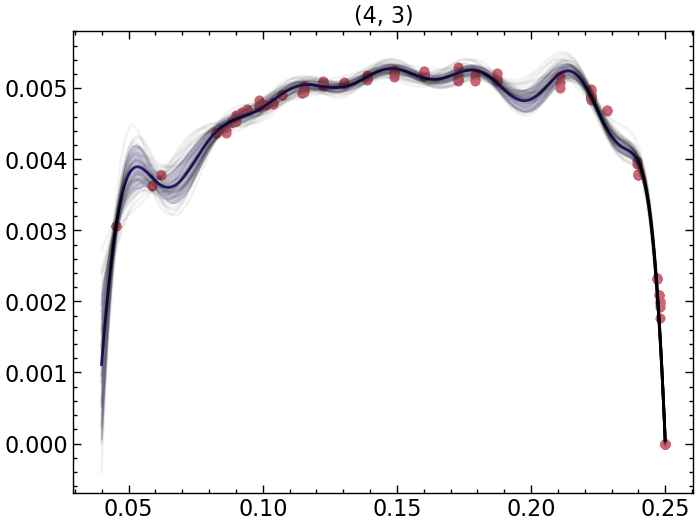

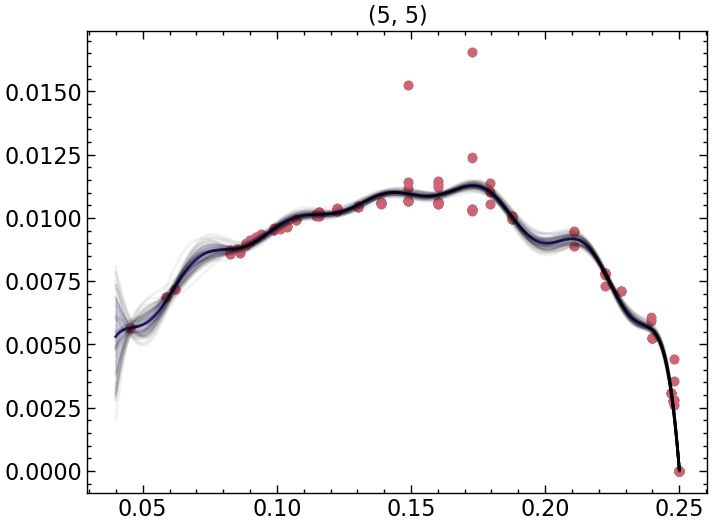

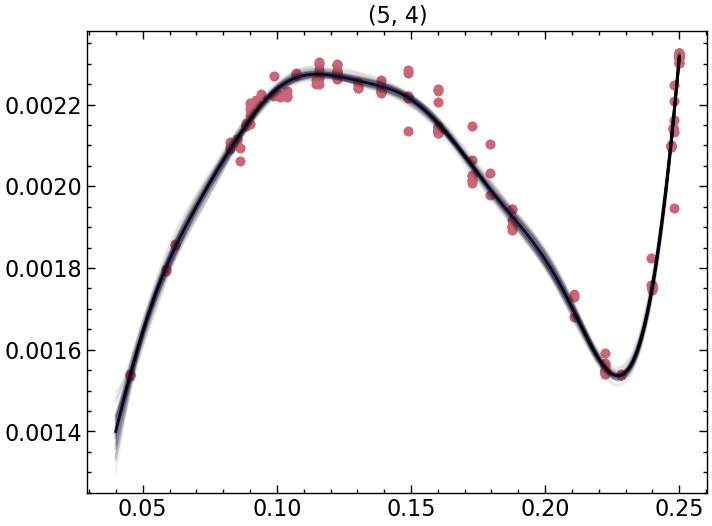

In [67]:
for mode in modes:
    plt.figure()
    pred_prime, pstd_prime, pcov = model[mode].predict(xx, return_std=True, return_cov=True)
    
    # Re-sampling from the predicted mean and covariance to verify the mean and covariance.
    ys_samples = np.random.multivariate_normal(pred_prime, pcov, size=50)
    
    plt.plot(phenom.eta_from_q(qs), get_peak_amp(wfs, mode), 'o')

    mu_ = y_ss[mode].inverse_transform(pred_prime[:,np.newaxis])[:,0]
    lower_ = y_ss[mode].inverse_transform((pred_prime-pstd_prime)[:,np.newaxis])[:,0]
    upper_ = y_ss[mode].inverse_transform((pred_prime+pstd_prime)[:,np.newaxis])[:,0]

    
    plt.plot(xx, mu_, c='C1')
    plt.fill_between(xx[:,0], lower_, upper_, color='C1', alpha=0.2)
    
    
    for ys_sample in ys_samples:
        plt.plot(xx, y_ss[mode].inverse_transform(ys_sample[:,np.newaxis]), "k-", alpha=0.05)

    # plt.xscale('log')
    # plt.xlim(0.15,0.25)
    plt.title(mode)
    plt.show()
    plt.close()

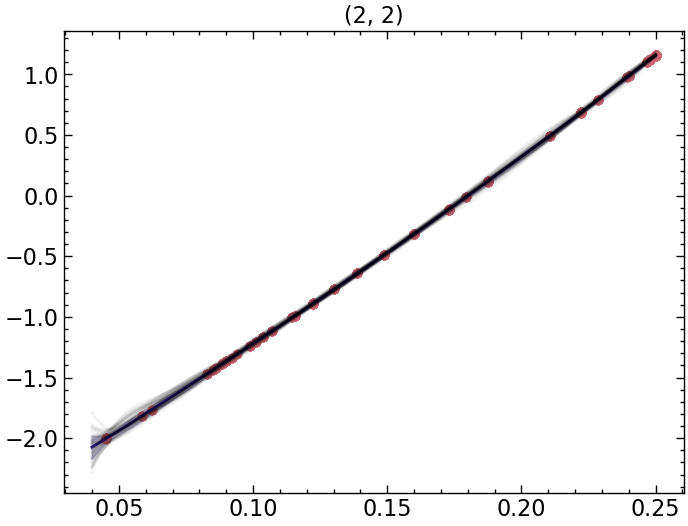

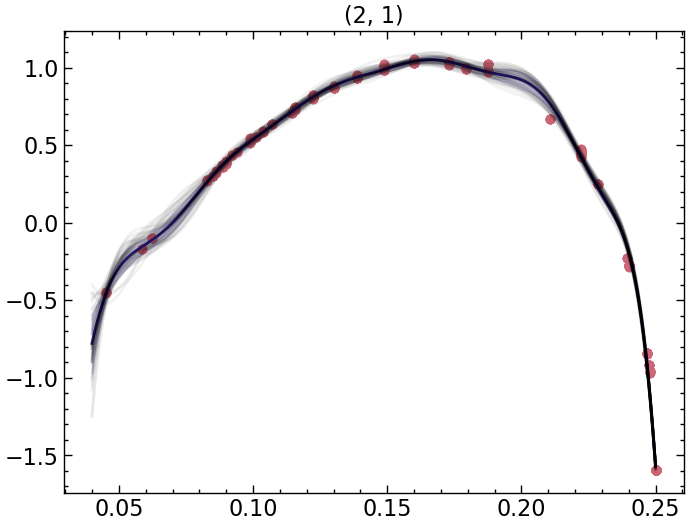

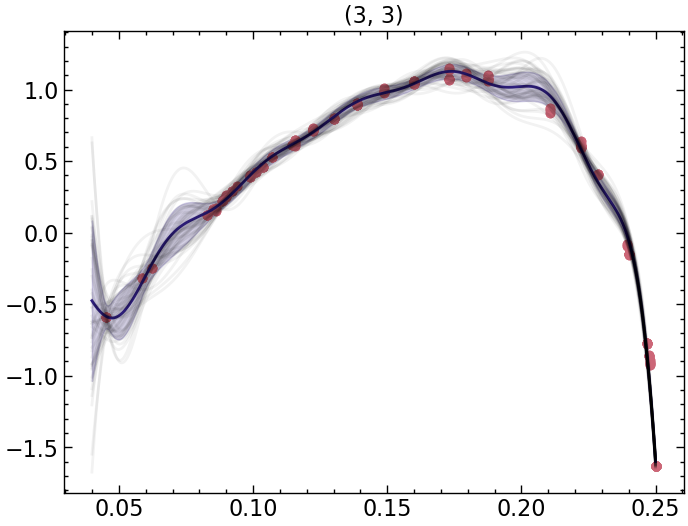

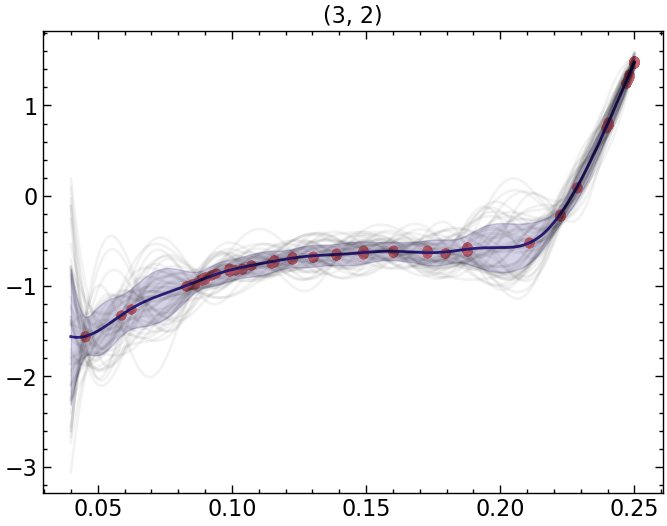

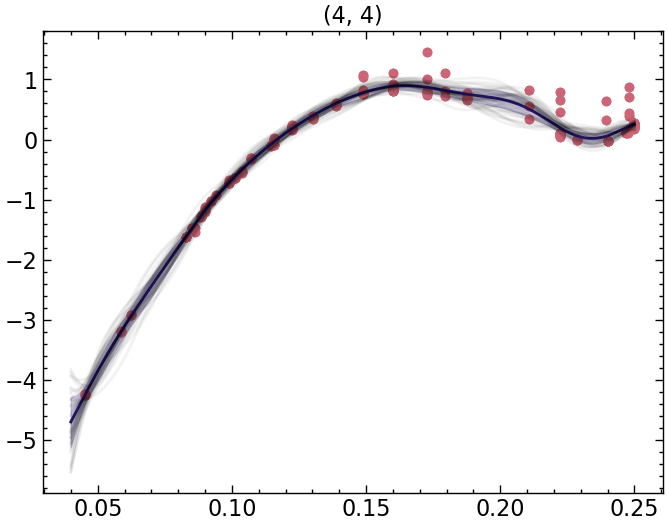

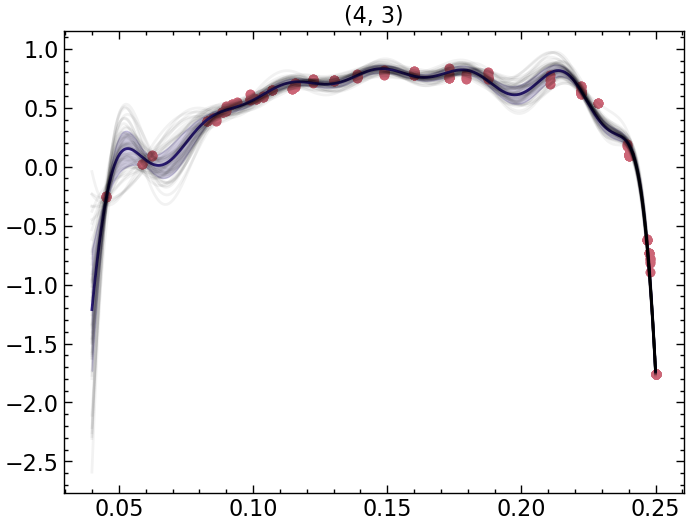

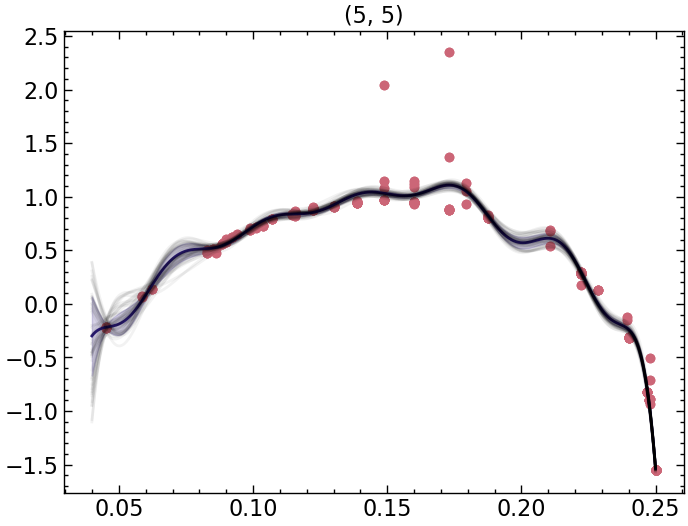

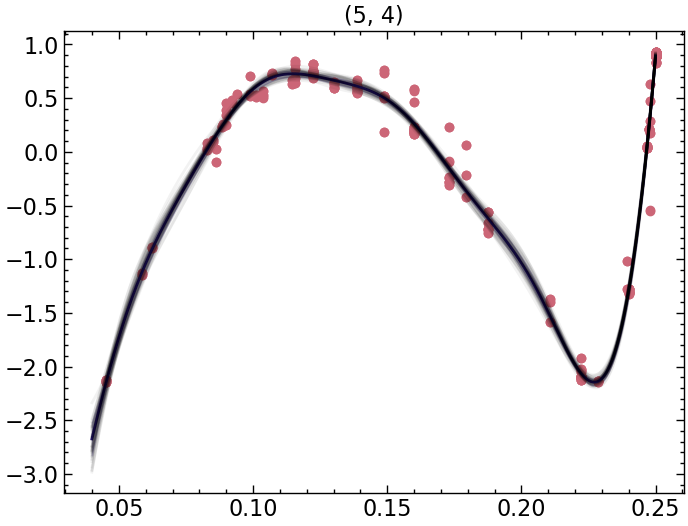

In [68]:
# no scaling
for mode in modes:
    plt.figure()
    pred_prime, pstd_prime, pcov = model[mode].predict(xx, return_std=True, return_cov=True)
    
    # Re-sampling from the predicted mean and covariance to verify the mean and covariance.
    ys_samples = np.random.multivariate_normal(pred_prime, pcov, size=50)
    
    plt.plot(phenom.eta_from_q(qs), y_ss[mode].transform(get_peak_amp(wfs, mode)[:,np.newaxis])[:,0], 'o')

    mu_ = pred_prime
    lower_ = pred_prime-pstd_prime
    upper_ = pred_prime+pstd_prime

    
    plt.plot(xx, mu_, c='C1')
    plt.fill_between(xx[:,0], lower_, upper_, color='C1', alpha=0.2)
    
    
    for ys_sample in ys_samples:
        plt.plot(xx, ys_sample, "k-", alpha=0.05)

    # plt.xscale('log')
    # plt.xlim(0.15,0.25)
    plt.title(mode)
    plt.show()
    plt.close()

In [53]:
# need plotly for these
# from optuna.visualization import plot_contour
# from optuna.visualization import plot_edf
# from optuna.visualization import plot_intermediate_values
# from optuna.visualization import plot_optimization_history
# from optuna.visualization import plot_parallel_coordinate
# from optuna.visualization import plot_param_importances
# from optuna.visualization import plot_rank
# from optuna.visualization import plot_slice
# from optuna.visualization import plot_timeline

In [54]:
# plot_slice(study[2,2])